In [2]:
import numpy as np
import numpy.fft as fft
import math
import matplotlib.pyplot as plt
%matplotlib inline

Test loss : -0.08898782106518964
0,0 : -0.459
0,1 : -0.009420194317589116
0,2 : -0.017346071886657308
Test loss : 0.0030063666942714753
1,0 : -0.01467935927768533
1,1 : -0.012970242814348233
1,2 : -0.011648977757220468
Test loss : 0.003498290280955341
2,0 : -0.010632750263286568
2,1 : -0.009826205342357713
2,2 : -0.009173558932248006
Test loss : 0.003648770587791955
3,0 : -0.008632803177192238
3,1 : -0.008175281653296491
3,2 : -0.007780452019193358
Final test loss : 0.0037019698221893212


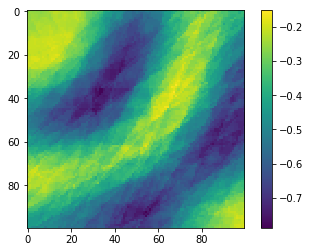

In [28]:
golden = 1.61803398875

#ground truth function
def drop_wave(vec):
    x = vec[0]
    y = vec[1]
    numerator = 1.0 + math.cos(12*math.sqrt((x**2) + (y**2)))
    demoninator = (0.5*((x**2) + (y**2))) + 2.0
    return -1*(numerator/demoninator)
dw = np.vectorize(drop_wave, signature='(n)->()')

nsamp = 1000       #number of training data samples
nsamp_test = 200   #number of test data samples

#training data
input_vecs = np.random.random((nsamp,2))
input_labels = np.around(dw(input_vecs))

#test_data
test_vecs = np.random.random((nsamp_test,2))
test_labels = dw(test_vecs)

#hyperparameters
func_res = 16 #1D projection sample table resolution
nfuncs = 16   #number of 1D projections

#function dimentions, technically hardcoded here in severeal other functions
#so not changeable, just useful to have a name to a constant
in_dim = 2
out_dim = 1

#squaring the circle, input data is confined to a square, useful part of ouput function confined to a circle
#this constant exponentially wastes data the higher the dimensionality, but gets a much more useable result
rotation_reduction = math.sqrt(in_dim)

#sets the center of rotation
rotation_global_trans = np.array([0.5 for i in range(0,in_dim)])

#cheap trick to get slightly higher resolution, 
#offset each 1D projection by a small ammount so the end results dont line up as a grid. 
f_trans = ((rotation_reduction/func_res)/nfuncs)

#the actual learned funtion table comprised of (N x Out dimensions x Input dimensions) 1D sample tables of M resolution
func_net = np.zeros([nfuncs,out_dim,in_dim,func_res])

#generate a rotation matrix to rotate the projections
#there are more effecient ways of doing this in higher dimentions, but for a 2x1 function it is fine
def gen_rot_mat(rad):
    return np.array([
        [math.cos(rad),-math.sin(rad)],
        [math.sin(rad), math.cos(rad)]
    ])


#forward pass per projection table
def func_function_forward(n,samples):
    #rotation reduction nessicary to make sure every function covers every vector rotation
    return samples[int( (n*(samples.shape[0])) / rotation_reduction )]
xff = np.vectorize(func_function_forward, signature='(),(n)->()')

#sum the result of every projection pass
def func_forward(vec,mat):
    return sum(xff(vec,mat)) #average
xf = np.vectorize(func_forward, signature='(n),(n,m)->()')

#generate a full forward pass on a set of vectors
def gen_full_forward(vecs,net):
    fpass = np.zeros(vecs.shape[1])
    for f in range(0,nfuncs):
        fpass = fpass + xf(vecs[f],net[f])
    return fpass / nfuncs

#rotate a set of vectors
def rot(vec,mat):
    return np.matmul(vec-rotation_global_trans,mat)+rotation_global_trans
r = np.vectorize(rot, signature='(n),(n,n)->(n)')

#envelope for updateing the tables during the backward pass based on error
lr = 0.15    #learning rate
lrange = 0.2 #maximum area in the function each sample can affect
def learning_envelope(offset,updating,res,error):
    dist = math.fabs((updating*(res)/rotation_reduction) - offset)
    if dist <= lrange:
        return ((lrange-dist) * lr * error) #sad stepped triangle envelope
    else:
        return 0

#a smoothing kernel to apply to the function to reduce noise
kernel = np.array([math.cos(k * ( (math.pi/1.5)/((func_res/2.0)+1) ) ) for k in range(0,int(func_res/2.0)+1)])#cosine frequency ramp (blur)
#print(kernel)
def apply_filter_kernel(f):
    fourier = fft.rfft(f)
    return fft.irfft(np.multiply(fourier,kernel))
fk = np.vectorize(apply_filter_kernel, signature='(n)->(n)')

#number of passes to run the learning
iters = 3
epochs = 4

#pre-calculate all of the rotated and translated input vectors for each of the projections
rot_in = np.array([[v+(f_trans*f) for v in r(input_vecs,gen_rot_mat( (math.pi*2*golden)*f ))] for f in range(0,nfuncs)])
test_rot_in = np.array([[v+(f_trans*f) for v in r(test_vecs,gen_rot_mat( (math.pi*2*golden)*f ))] for f in range(0,nfuncs)])

err = float('inf')
for e in range(0,epochs):
    #get the error on the test data
    lpass = gen_full_forward(test_rot_in, func_net)
    loss = sum(test_labels-lpass)/nsamp
    print("Test loss : " + str(loss))
    
    for c in range(0,iters):         
        #get the error on the training data
        fpass = gen_full_forward(rot_in,func_net)
        err = sum(input_labels-fpass)/nsamp
        print(str(e) + "," + str(c) + " : " +str(err))

        #for each projection
        for f in range(0,nfuncs):
            #for each training sample
            for k,i in enumerate(rot_in[f]):
                #for each dimension
                for d in range(0,in_dim):
                    for m in range(0,out_dim):
                        #apply the learning envelop to every sample table value in the projection
                        envelope = np.array([learning_envelope(j,i[d],func_res,input_labels[k]-fpass[k]) for j in range(0,func_res)])
                        func_net[f][m][d] = func_net[f][m][d]+envelope    
                        
        #smooth the output between every epoch
        func_net = fk(func_net)
        
#get the error on the test data
lpass = gen_full_forward(test_rot_in, func_net)
loss = sum(test_labels-lpass)/nsamp
print("Final test loss : " + str(loss))
                    
#create a 100 x 100 view of the learned function and display it
out = np.array([[0.0 for x in range(0,100)] for y in range(0,100)])
for f in range(0,nfuncs):
    out = out + np.array([[xf([rot([ x/100.0, y/100.0 ],gen_rot_mat( (math.pi*2*golden)*f ))+(f_trans*f)],func_net[f])[0] for x in range(0,100)] for y in range(0,100)])
out = out / nfuncs

#print(out)
plt.figure()
plt.imshow(out)
plt.colorbar()
    

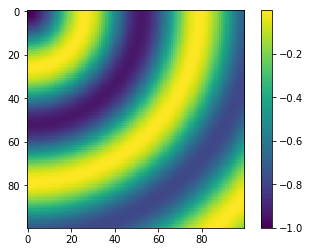

In [29]:
n_out = np.array([[drop_wave([x/100.0,y/100.0]) for x in range(0,100)] for y in range(0,100)])
plt.figure()
plt.imshow(n_out)
plt.colorbar()
